In [1]:
%load_ext autoreload
%autoreload 2

import os
import anndata as ad
import scanpy as sc
from scalex_mp import SCALEXLogic

In [2]:
src = "D:/2021-11_livecell_growth/adata"
adata_fn = "adata_final_fs.h5ad"
adata = ad.read_h5ad(os.path.join(src, adata_fn))
adata

AnnData object with n_obs × n_vars = 7661 × 420
    obs: 'ImageNumber', 'ObjectNumber', 'Metadata_Field', 'Metadata_FileLocation', 'Metadata_Frame', 'Metadata_Marker', 'Metadata_Series', 'Metadata_Time', 'Metadata_Well', 'Cells_Location_CenterMassIntensity_X_Cytoskeleton', 'Cells_Location_CenterMassIntensity_X_Mito', 'Cells_Location_CenterMassIntensity_Y_Cytoskeleton', 'Cells_Location_CenterMassIntensity_Y_Mito', 'Cells_Location_CenterMassIntensity_Z_Cytoskeleton', 'Cells_Location_CenterMassIntensity_Z_Mito', 'Cells_Location_Center_X', 'Cells_Location_Center_Y', 'Cells_Location_Center_Z', 'Cells_Location_MaxIntensity_X_Cytoskeleton', 'Cells_Location_MaxIntensity_X_Mito', 'Cells_Location_MaxIntensity_Y_Cytoskeleton', 'Cells_Location_MaxIntensity_Y_Mito', 'Cells_Location_MaxIntensity_Z_Cytoskeleton', 'Cells_Location_MaxIntensity_Z_Mito', 'Cells_Parent_Nuc_10', 'Cells_Parent_Primarieswithoutborder', 'Primarieswithoutborder_Location_CenterMassIntensity_X_DNA', 'Primarieswithoutborder_Locat

In [3]:
batch_var = 'PlateNumber'
treat_var = 'Metadata_Treatment'
time_var = 'Metadata_Time'

In [4]:
adata.obs[batch_var] = adata.obs[batch_var].astype('category')

In [5]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

C:\Users\amarx\Anaconda3\envs\scalex\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\amarx\Anaconda3\envs\scalex\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


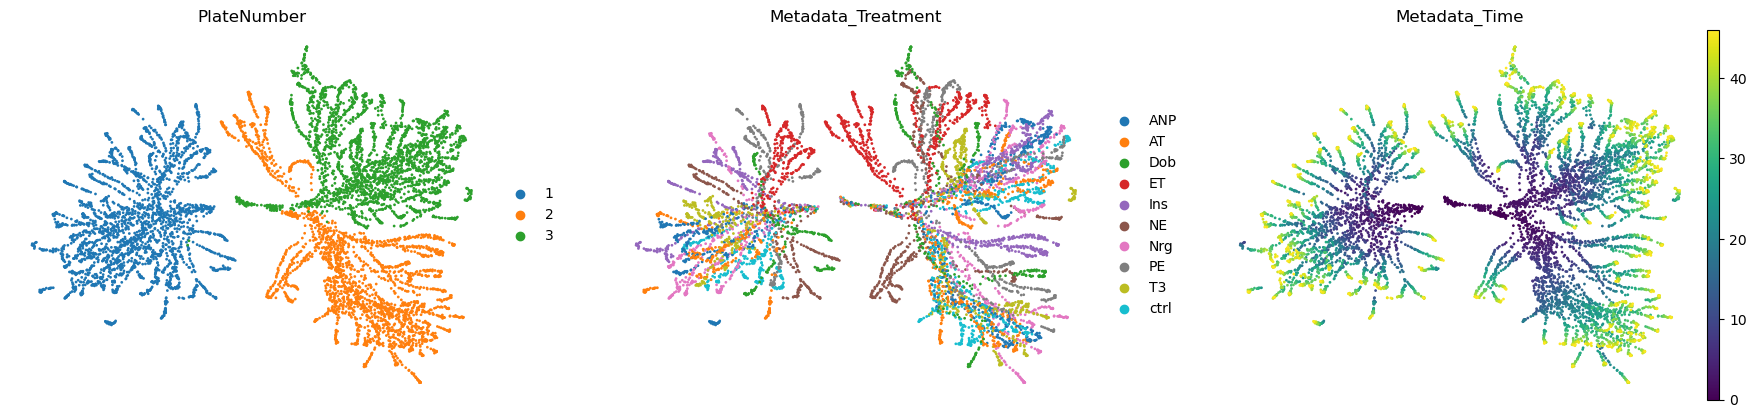

In [6]:
sc.pl.umap(adata, color=[batch_var, treat_var, time_var], frameon=False)

In [7]:
logic = SCALEXLogic(
    adata=adata, num_workers=0,
    kld_beta=0.001, batch_key=batch_var
)

In [ ]:
logic.fit(max_epochs=20, wandb_log=False)

In [5]:
# load pretrained model
model_path = "./checkpoints/epoch=18_best_loss.ckpt"
logic = SCALEXLogic.from_checkpoint(model_path, adata=adata, num_workers=0)

In [6]:
adata = logic.get_latent()

Get latent: 100%|██████████| 240/240 [00:06<00:00, 37.77it/s]


In [7]:
sc.pp.neighbors(adata, use_rep='X_latent')
sc.tl.umap(adata)

C:\Users\amarx\Anaconda3\envs\scalex\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\amarx\Anaconda3\envs\scalex\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


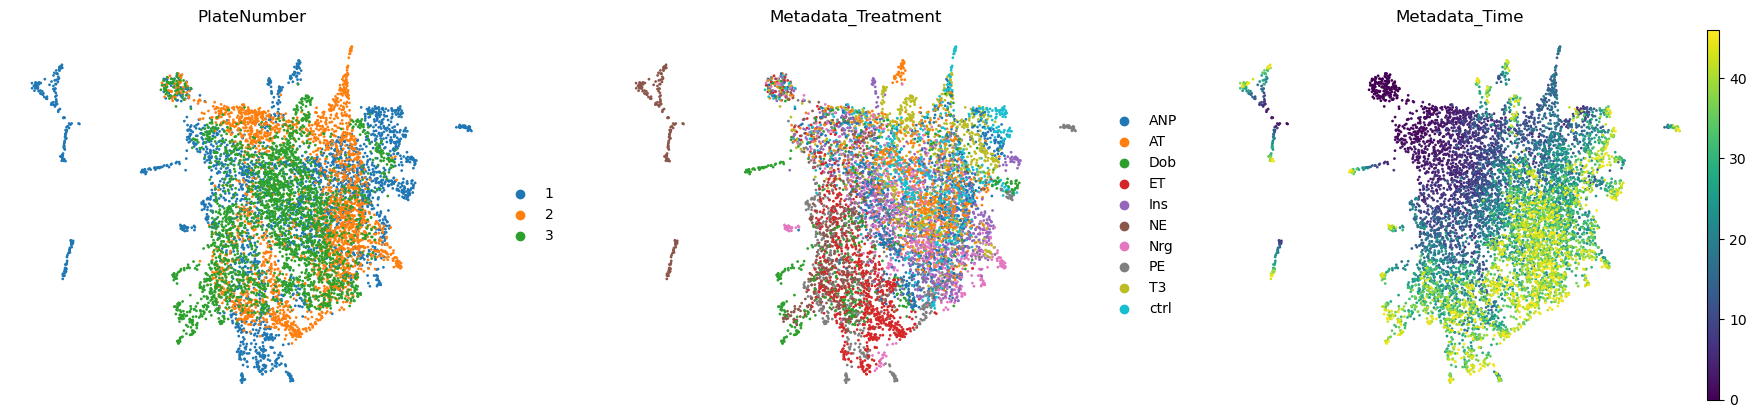

In [8]:
sc.pl.umap(adata, color=[batch_var, treat_var, time_var], frameon=False)
